# Initialization


## Loading of modules & GPU Check

This is taken from the baseline code, few other imports e.g.: livelossplot is added to enable live observation of the train/validation loss. Numpy had to be updated to work correctly with pickle. 

In [0]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
!pip install livelossplot
!pip3 install --upgrade numpy

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.16.1)


In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [0]:
printm()

Gen RAM Free: 12.9 GB  | Proc size: 142.3 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Download & Unpack the data (Run only if not done already)
This block simply downloads the data and unzips it for training/testing. 

In [0]:
# Clone repo
!git clone https://github.com/alopezgit/keras_triplet_descriptor
# Change directory
%cd /content/keras_triplet_descriptor
!git checkout 719576a29567a9a2b86658496eea7f196bc314f6
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

Cloning into 'keras_triplet_descriptor'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 65 (delta 26), reused 31 (delta 9), pack-reused 0
Unpacking objects: 100% (65/65), done.
/content/keras_triplet_descriptor
--2019-02-03 10:32:35--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 185.235.236.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-02-03 10:32:35--  https://imperialcollegelondon.app.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.box.

## Imports of modules

In [0]:
import sys, json, os, glob, time, cv2, random
import keras
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Flatten, Input, Lambda, Reshape, Subtract, AveragePooling2D, Add
from keras.layers import Conv2D, BatchNormalization 
from keras.layers import Input
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import plot_model, np_utils


import tensorflow as tf
import numpy as np
import pickle


from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Fixation of seeds 

We keep the seeds for random number generators fixed so that the results are reproducible. 

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

## Loading of splits

Here we load the train and test data both locations for the descriptor network and also for the denoising network. 

The winning model contained 2 networks.

The denoising network contained 3 7x7 Convolution, 5 5x5 Convolutions and 9 3x3 Convolutions, while the depth of the model was 128 filters. 

The descriptor network used ResNet v2 with the depth of 20. 

The models are visualised while being loaded in their respective blocks. You can find the visualisations in the `keras_triplet_descriptor` folder as `.png` images.  

Note, that the visualisation of the loss function is not working beacuse there are some internal compatibility issues between numpy and pickle. The plots were orginally generated on an external server outisde the Colab environment. 

In [0]:
# If you wish to train from scratch, set training to True
denoise_train = False
descriptor_train = False
plot = True

# Define the parameters for the winning models
denoise_layer_n = [3,5,9]
denoise_filters = 128
descriptor_depth = 20

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))

split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 

# Model definitions



## Denoise Model

The denoise model is closely following DNCNN [Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising](https://arxiv.org/abs/1608.03981)

The original code can be found here: https://github.com/cszn/DnCNN/tree/master/TrainingCodes/dncnn_keras.

The difference between the original network and this implementation is in in inclusion of 2 more subtraction blocks with varying number of kernel sizes, while the number of filters stays constant. 

In [0]:
SHAPE = (32, 32, 1)

def denoise_residual_block(inpt, depth = 2, filters = 32,
                           kernel_size = 3, strides = 1):

  n = inpt
  for i in range(depth):
    n = Conv2D(filters=filters, kernel_size=(kernel_size,kernel_size), strides=(strides,strides),
             kernel_initializer='he_normal', padding='same',kernel_regularizer = l2(1e-4))(n)
    n = BatchNormalization()(n)
    n = Activation("relu")(n)
  return n

    
  
def get_denoise_model(shape,filters, n_nodes):
  inpt = Input(shape=shape)
  
  x = Conv2D(filters=filters, kernel_size=(9,9), strides=(1,1),
             kernel_initializer='orthogonal', padding='same', kernel_regularizer = l2(1e-4))(inpt)
  
  n1 = denoise_residual_block(x, n_nodes[0], filters, 7, 1)
  y = Subtract()([x, n1])   # input - noise
  n2 = denoise_residual_block(y, n_nodes[1], filters, 5, 1)
  y = Subtract()([y, n2])   # input - noise
  n3 = denoise_residual_block(y, n_nodes[2], filters, 3, 1)
  y = Subtract()([y, n3])   # input - noise
  
  out = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1),
             kernel_initializer='orthogonal', padding='same', kernel_regularizer = l2(1e-4))(y)

  model = Model(inputs=inpt, outputs=out)
    
  return model

## Descriptor model

Descriptor model copies the original ResNet v2 from [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027).

The original code can be found here: https://github.com/broadinstitute/keras-resnet.

The main difference is that the last layer was adapted to produce a 128-dimensional output to match the specification and the input dimensions into the HPatches framework. The original combination of the descriptor networks to match the triplet loss was not changed from the baseline.

In [0]:
def residual_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def get_descriptor_model(input_shape, depth=20):
    if (depth - 2) % 9 != 0:
        raise ValueError('Depth should be 9n+2 (eg 56 or 110)')
    
    # Start model definition.
    num_filters_in = 8
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    x = residual_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:
                    strides = 2

            # Bottleneck residual unit
            y = residual_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = residual_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = residual_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                x = residual_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
                
            x = Add()([x, y]) 

        num_filters_in = num_filters_out

    # Cater for the input dimensions of HPatches
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer="he_normal")(x)
    x = Reshape((128,))(x)

    model = Model(inputs=inputs, outputs=x)
    return model

def get_descriptor_model_connected(shape, depth):
  xa = Input(shape=shape, name='a')
  xp = Input(shape=shape, name='p')
  xn = Input(shape=shape, name='n')
  descriptor_model = get_descriptor_model(shape, depth)
  ea = descriptor_model(xa)
  ep = descriptor_model(xp)
  en = descriptor_model(xn)

  loss = Lambda(triplet_loss)([ea, ep, en])
  model = Model(inputs = [xa, xp, xn], outputs = loss)
  return model, descriptor_model

## Loss definition

Define the same loss as used in the baseline method for the descriptor network. The denoising architecture uses mean-squared error and does not need a separate function for the loss. 

In [0]:
# Descriptor loss
def triplet_loss(x):
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

# Training: Denoise model

For the collection of the results that gave the starting insight the parameters are summarized in the comments below. We define a set of callbacks to limit the training such that the model avoids overfitting/underfitting.

## Loading of the data

In [0]:
# Denoising data
denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 40/40 [00:38<00:00,  1.02it/s]


In [0]:
#Training: steps_per_epoch = 31179, validation_steps = 19050, epochs = 20
#Collection of results as plotted in figures: steps_per_epoch = 2000, validation_steps = 200, epochs = 2
denoise_model = get_denoise_model(SHAPE, denoise_filters, denoise_layer_n)
denoise_history = None

def lr_schedule_denoise(epoch):
    initial_lr = 0.001
    if epoch<=5:
        lr = initial_lr
    elif epoch<=10:
        lr = initial_lr/10
    elif epoch<=15:
        lr = initial_lr/20 
    else:
        lr = initial_lr/20 
    return lr

# Define the callbacks
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, mode= 'auto')
lr_scheduler = LearningRateScheduler(lr_schedule_denoise)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)  

callbacks_list = [early_stopping, lr_scheduler, lr_reducer]
denoise_model = get_denoise_model(SHAPE, denoise_filters, denoise_layer_n)
denoise_model.compile(optimizer=Adam(0.001), loss='mean_squared_error')

In [0]:
# Plot the architecture of the model together with its summary and number of trainable parameters
if plot == True:
  plot_model(denoise_model, to_file='improved_denoise_arch.png')
  print(denoise_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 32, 32, 128)  10496       input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 32, 32, 128)  802944      conv2d_103[0][0]                 
__________________________________________________________________________________________________
batch_normalization_89 (BatchNo (None, 32, 32, 128)  512         conv2d_104[0][0]                 
__________________________________________________________________________________________________
activation

In [0]:
# If previously defined that we are training, train it from scratch
# If not simply load the history from a file
if denoise_train == True:
  denoise_history = denoise_model.fit_generator(generator=denoise_generator,
                                                epochs=20,
                                                verbose=1,
                                                callbacks=callbacks_list,
                                                validation_data=denoise_generator_val,
                                                workers=1,
                                                steps_per_epoch = 31179,
                                                validation_steps = 19050,
                                                use_multiprocessing=False
                                               )
  denoise_history = denoise_history.history
else:
  with open('improved_denoise_history.pck', 'rb') as file_pi:
    denoise_history = pickle.load(file_pi, encoding='latin-1')
  denoise_model.load_weights('improved_denoise.h5')

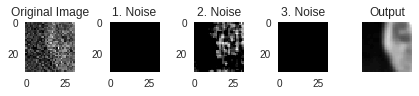

In [0]:
# Plot the intermediate results wheile filtering an image from noise on a random image.
# Plot what has each noise-loop learned and how it approaximately removes the noise from the distorted image
# The activations have to be manually specified because their name changes every time :( 

if plot == True:
  img = denoise_generator_val[np.random.randint(0, len(denoise_generator_val))][0][0]
  _img = np.expand_dims(img, 0) 
  model_layers = [ layer.name for layer in denoise_model.layers]
  subtract_layers = [i for i in model_layers if "subtract" in i]
  subtract_layers = ["activation_91", "activation_96", "activation_105"]
  subtract_extractors = [Model(inputs=denoise_model.input, outputs=denoise_model.get_layer(i).output) 
                         for i in subtract_layers]
  
  output = denoise_model.predict(_img)
  
  fig, axs = plt.subplots(1,len(subtract_layers) + 2)
  plt.axis("off")

  fig.tight_layout()
  axs[0].set_title("Original Image")
  axs[0].imshow(img.astype(np.uint8).reshape((32,32)), cmap='gray')
  axs[0].grid(False)

  
  for i,extractor in enumerate(subtract_extractors):
    features = extractor.predict(_img)
    axs[i+1].imshow(features[0, :, :, np.random.randint(0, 128)], cmap='gray')
    axs[i+1].set_title("{}. Noise".format(i+1))
    axs[i+1].grid(False)

    
  axs[len(subtract_layers)+1].imshow(output.astype(np.uint8).reshape((32,32)), cmap='gray')
  axs[len(subtract_layers)+1].set_title("Output".format(i+1))
  axs[len(subtract_layers)+1].grid(False)

## Plot sample image

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


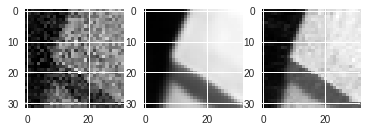

In [0]:
if plot == True:
  plot_denoise(denoise_model)

## Save Weights

In [0]:
if denoise_train == True:
  denoise_model.save('improved_denoise_complete.h5')
  denoise_model.save_weights('improved_denoise.h5')
  with open('improved_denoise_history.pck', 'wb') as file_pi:
    pickle.dump(denoise_history, file_pi)

## Plot Loss

In [0]:
# Summarize history for loss
# NOTE: does not work on Google Colab, please refer to the report
if plot == True:
  plt.plot(denoise_history['loss'])
  plt.plot(denoise_history['val_loss'])
  plt.title('Improved model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

# Training: Descriptor model

For the collection of the results that gave the starting insight the parameters are summarized in the first comment. We define a set of callbacks to limit the training such that the model avoids overfitting/underfitting.

## Loading of data



In [0]:
if descriptor_train == True:
  hPatches = HPatches(train_fnames = train_fnames, test_fnames = test_fnames)
  descriptor_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train = 1), num_triplets = 100000)
  descriptor_generator_val = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train = 0), num_triplets = 10000)

100%|██████████| 116/116 [00:35<00:00,  2.75it/s]


97435


100%|██████████| 116/116 [00:22<00:00,  5.20it/s]


59532


100%|██████████| 10000/10000 [00:00<00:00, 69433.61it/s]


In [0]:
# Training: steps_per_epoch = 2000, validation_steps = 200, epochs = 20
# Collection of results as plotted in figures:: steps_per_epoch = 2000, validation_steps = 200, epochs = 2

descriptor_model_connected, descriptor_model = get_descriptor_model_connected(SHAPE, descriptor_depth)
descriptor_history = None
def lr_schedule_descriptor(epoch):
    initial_lr = 0.0001
    if epoch<=5:
        lr = initial_lr
    elif epoch<=10:
        lr = initial_lr/10
    elif epoch<=15:
        lr = initial_lr/20 
    else:
        lr = initial_lr/20 
    return lr

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto')
lr_scheduler = LearningRateScheduler(lr_schedule_descriptor)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks_list = [early_stopping, lr_scheduler, lr_reducer]

descriptor_model_connected.compile(loss="mean_squared_error", optimizer=Adam(0.001))


In [0]:
# Plot the architecture of the model together with its summary and number of trainable parameters
if plot == True:
  plot_model(descriptor_model, to_file='improved_descriptor_arch.png')
  print(descriptor_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 32, 32, 8)    80          input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 32, 32, 8)    32          conv2d_122[0][0]                 
__________________________________________________________________________________________________
activation_106 (Activation)     (None, 32, 32, 8)    0           batch_normalization_106[0][0]    
__________________________________________________________________________________________________
conv2d_123

In [0]:
# If previously defined that we are training, train it from scratch
# If not simply load the history from a file
if descriptor_train == True:
  descriptor_history = descriptor_model_connected.fit_generator(generator=descriptor_generator,
                                                                callbacks=callbacks_list,
                                                                epochs=20, verbose=1,
                                                           validation_data=descriptor_generator_val,
                                                           workers=1,
                                                           steps_per_epoch = 2000,
                                                           validation_steps = 200,
                                                           use_multiprocessing=False,)
else:
  with open('improved_descriptor_history.pck', 'rb') as file_pi:
    descriptor_history = pickle.load(file_pi)
  descriptor_model.load_weights('improved_descriptor.h5')

## Save Weights

In [0]:
if descriptor_train == True:
  descriptor_model.save_weights('improved_descriptor.h5')
  with open('improved_descriptor_history.pck', 'wb') as file_pi:
    pickle.dump(descriptor_history, file_pi)

## Plot Loss

In [0]:
# Summarize history for loss
# NOTE: does not work on Google Colab, please refer to the report
if plot == True:
  plt.plot(descriptor_history.history['loss'])
  plt.plot(descriptor_history.history['val_loss'])
  plt.title('Improved model loss - Descriptor')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

# Evaluation

In [0]:
# Just in case remove any previous results, such that the results are freshly generated and not biased from aprevious run
!rm -rf out/
!rm -rf results/
generate_desc_csv(descriptor_model, denoise_model, seqs_test)

100%|██████████| 40/40 [52:56<00:00, 78.33s/it]


In [0]:
!git clone https://github.com/hpatches/hpatches-benchmark

Cloning into 'hpatches-benchmark'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 1435 (delta 11), reused 14 (delta 5), pack-reused 1409
Receiving objects: 100% (1435/1435), 239.72 MiB | 20.10 MiB/s, done.
Resolving deltas: 100% (789/789), done.
Checking out files: 100% (135/135), done.


## Verification


In [0]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=verification


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:39<00:00, 10074.95it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:39<00:00, 10086.08it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:39<00:00, 10052.46it/s]
>> Verification task finished in 307 secs  
Verification task results:
CUSTOM - Balanced variant (auc) 
Noise       Inter     Intra
-------  --------  --------
Easy     0.943892  0.914343
Hard     0.92641   0.889426
Tough    0.897927  0.852676
CUSTOM - Imbalanced variant (ap) 
Noise       Inter     Intra
-------  --------  --------
Easy     0.852566  0.770472
Hard     0.795039  0.683262
Tough    0.71381   0.583898


## Retrieval

In [0]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=retrieval


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc 1600004096 bytes == 0x26842000 @  0x7f64ea9df1e7 0x7f64e011dde1 0x7f64e0182868 0x7f64e0182e37 0x7f64e021cc48 0x5030d5 0x507641 0x504c28 0x502540 0x502f3d 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x506393 0x634d52 0x634e0a 0x6385c8 0x63915a 0x4a6f10 0x7f64ea5dcb97 0x5afa0a
>> Distance matrix done.
Processing retrieval task: 100% 10000/10000 [04:05<00:00, 40.81it/s]
>> Retrieval task finished in 264 secs  
Retrieval task results:
CUSTOM - mAP 10K queries 
Noise         100       500      1000      5000     10000     15000     20000
-------  --------  --------  --------  --------  --------  --------  --------
Easy     0.772724  0.634988  0.579343  0.459781  0.413209  0.38837   0.373258
Hard     0.714858  0.534951  0.461671  0.31055   0.2582

## Matching

In [0]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=matching


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:12<00:00,  4.50s/it]
>> Matching task finished in 133 secs  
Matching task results:
CUSTOM - mAP 
    Easy       Hard      Tough      mean
--------  ---------  ---------  --------
0.227388  0.0987057  0.0408514  0.122315




## Compressing and saving the CSV files 

In [0]:
!zip -rq descriptors.zip ./out/custom